 Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.
 
 Member 1: Pham, Doan Xuan Viet; 03698056

 Member 2: Schulz, Julien; 03723706
 
 Member 3: Jehkul, Janik; 03781262

In [1]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

In [2]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.squeeze().long()

            # TODO: Convert to binary classification
            # check if at least one disease label is present and convert to True/False
            if convert_to_binary:
                targets = torch.where(targets.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()
                
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()


            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [3]:
def test(model, data_loader, device, convert_to_binary):
    criterion_ce = nn.CrossEntropyLoss()
    model.eval()
    avg_loss = 0
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()

            # TODO: Convert to binary classification
            if convert_to_binary:
                targets = torch.where(targets.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()
                
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]
        TP = ((y_preds == 1) & (y_true == 1)).sum().item()
        TN = ((y_preds == 0) & (y_true == 0)).sum().item()
        FP = ((y_preds == 1) & (y_true == 0)).sum().item()
        FN = ((y_preds == 0) & (y_true == 1)).sum().item()

        # TODO: Accuracy
        acc = (TP + TN) / (TP + TN + FP + FN)

        # TODO: Positive rate
        positive_rate = TP / (TP + FN)
        print("Positive rate: ", positive_rate)

        # TODO: Negative rate
        negative_rate = TN / (TN + FP)
        print("Negative rate: ", negative_rate)

        # Balanced accuracy
        balanced_acc = (positive_rate + negative_rate) / 2
        print("Balanced accuracy: ", balanced_acc)
        
        print('acc: %.3f \n' % (acc))

# Chest

In [4]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'])

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

100%|██████████| 82802576/82802576 [00:03<00:00, 21707609.48it/s]


Using downloaded and verified file: /home/vietp/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/vietp/.medmnist/chestmnist.npz


In [96]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, num_classes),
            nn.ReLU()
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        if self.extract_embeddings:
            return x

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:00<00:00, 78.61it/s]


Epoch: 1	Loss: 0.6994


100%|██████████| 5/5 [00:00<00:00, 63.50it/s]


Epoch: 2	Loss: 0.6763


100%|██████████| 5/5 [00:00<00:00, 78.51it/s]


Epoch: 3	Loss: 0.6524


100%|██████████| 5/5 [00:00<00:00, 75.45it/s]


Epoch: 4	Loss: 0.6321


100%|██████████| 5/5 [00:00<00:00, 74.45it/s]


Epoch: 5	Loss: 0.6104


100%|██████████| 5/5 [00:00<00:00, 66.93it/s]


Epoch: 6	Loss: 0.5820


100%|██████████| 5/5 [00:00<00:00, 79.69it/s]


Epoch: 7	Loss: 0.5385


100%|██████████| 5/5 [00:00<00:00, 81.61it/s]


Epoch: 8	Loss: 0.5040


100%|██████████| 5/5 [00:00<00:00, 77.04it/s]


Epoch: 9	Loss: 0.4520


100%|██████████| 5/5 [00:00<00:00, 63.35it/s]


Epoch: 10	Loss: 0.4289


100%|██████████| 5/5 [00:00<00:00, 68.49it/s]


Epoch: 11	Loss: 0.3988


100%|██████████| 5/5 [00:00<00:00, 75.46it/s]


Epoch: 12	Loss: 0.3717


100%|██████████| 5/5 [00:00<00:00, 73.34it/s]


Epoch: 13	Loss: 0.3411


100%|██████████| 5/5 [00:00<00:00, 70.08it/s]


Epoch: 14	Loss: 0.3129


100%|██████████| 5/5 [00:00<00:00, 73.35it/s]


Epoch: 15	Loss: 0.2932


100%|██████████| 5/5 [00:00<00:00, 80.83it/s]


Epoch: 16	Loss: 0.2770


100%|██████████| 5/5 [00:00<00:00, 69.17it/s]


Epoch: 17	Loss: 0.2548


100%|██████████| 5/5 [00:00<00:00, 75.73it/s]


Epoch: 18	Loss: 0.2429


100%|██████████| 5/5 [00:00<00:00, 70.44it/s]


Epoch: 19	Loss: 0.2178


100%|██████████| 5/5 [00:00<00:00, 71.58it/s]

Epoch: 20	Loss: 0.2036


In [98]:
# Examine the data distribution of the binary classification task. Is accuracy a good metric?
print("Positive in train: " + str(sum(i.sum() > 0 for i in train_dataset_chest.labels)))
print("Negative in train: " + str(sum(i.sum() == 0 for i in train_dataset_chest.labels)) + "\n")
print("Positive in test:  " + str(sum(i.sum() > 0 for i in test_dataset_chest.labels)))
print("Negative in test:  " + str(sum(i.sum() == 0 for i in test_dataset_chest.labels)))

# Positive in train: 134 Negative in train: 166
# Positive in test:  10505 Negative in test:  11928

# Answer in report.

Positive in train: 134
Negative in train: 166

Positive in test:  10505
Negative in test:  11928


In [99]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_ae, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_ae, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
Positive rate:  0.9029850746268657
Negative rate:  0.9698795180722891
Balanced accuracy:  0.9364322963495775
acc: 0.940 

test
Positive rate:  0.5364112327463113
Negative rate:  0.6160295103957075
Balanced accuracy:  0.5762203715710095
acc: 0.579 



## Latent Space

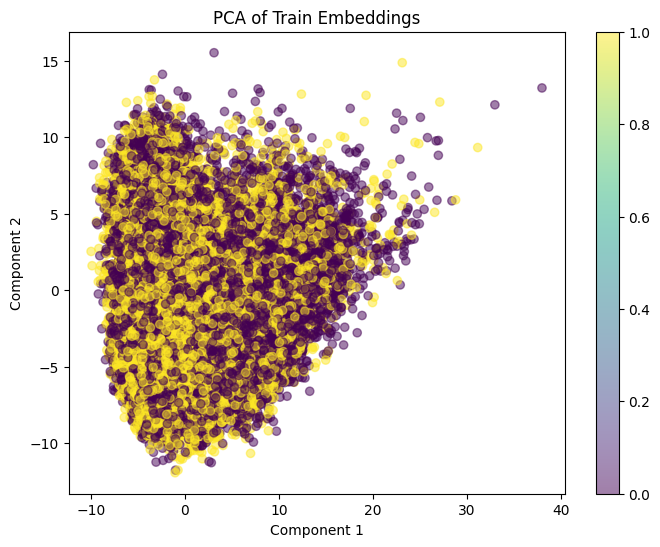

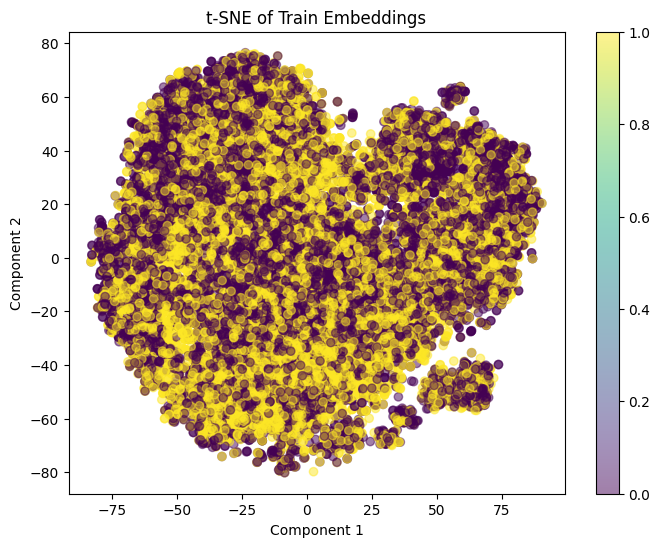

In [100]:
# EXAMINE LATENT SPACE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False
            
            embeddings.append(output)
            labels.append(target)
    
    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_ae)

# TODO: convert labels to binary
test_labels = torch.where(test_labels.sum(dim=1) > 0, torch.tensor([1]).to(device), torch.tensor([0]).to(device)).long()


import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE 
t_sne = TSNE(n_components=2)
tsne_result = t_sne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):
        super().__init__()
        # Encoder
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels_chest, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=p)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=p)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=p)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=p),
            nn.ConvTranspose2d(16, n_channels_chest, kernel_size=3, stride=2, padding=3, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # print(x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.decoder(x)
        return x

# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_ae(inputs)
        # print(inputs.shape)
        loss = criterion_ae(outputs, inputs)

        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')


Epoch [1/10], Loss: 0.1895, PSNR: 12.9683, SSIM: 0.1250
Epoch [2/10], Loss: 0.1579, PSNR: 13.9340, SSIM: 0.2035
Epoch [3/10], Loss: 0.1487, PSNR: 13.9842, SSIM: 0.2466
Epoch [4/10], Loss: 0.1471, PSNR: 14.0670, SSIM: 0.2640
Epoch [5/10], Loss: 0.1469, PSNR: 14.0021, SSIM: 0.2244
Epoch [6/10], Loss: 0.1302, PSNR: 14.5279, SSIM: 0.2874
Epoch [7/10], Loss: 0.1407, PSNR: 14.2255, SSIM: 0.2967
Epoch [8/10], Loss: 0.1309, PSNR: 14.6446, SSIM: 0.3595
Epoch [9/10], Loss: 0.1434, PSNR: 14.2482, SSIM: 0.2867
Epoch [10/10], Loss: 0.1408, PSNR: 14.4324, SSIM: 0.3363
Average Test Loss: 0.0021, Average PSNR: 14.7612, Average SSIM: 0.3493


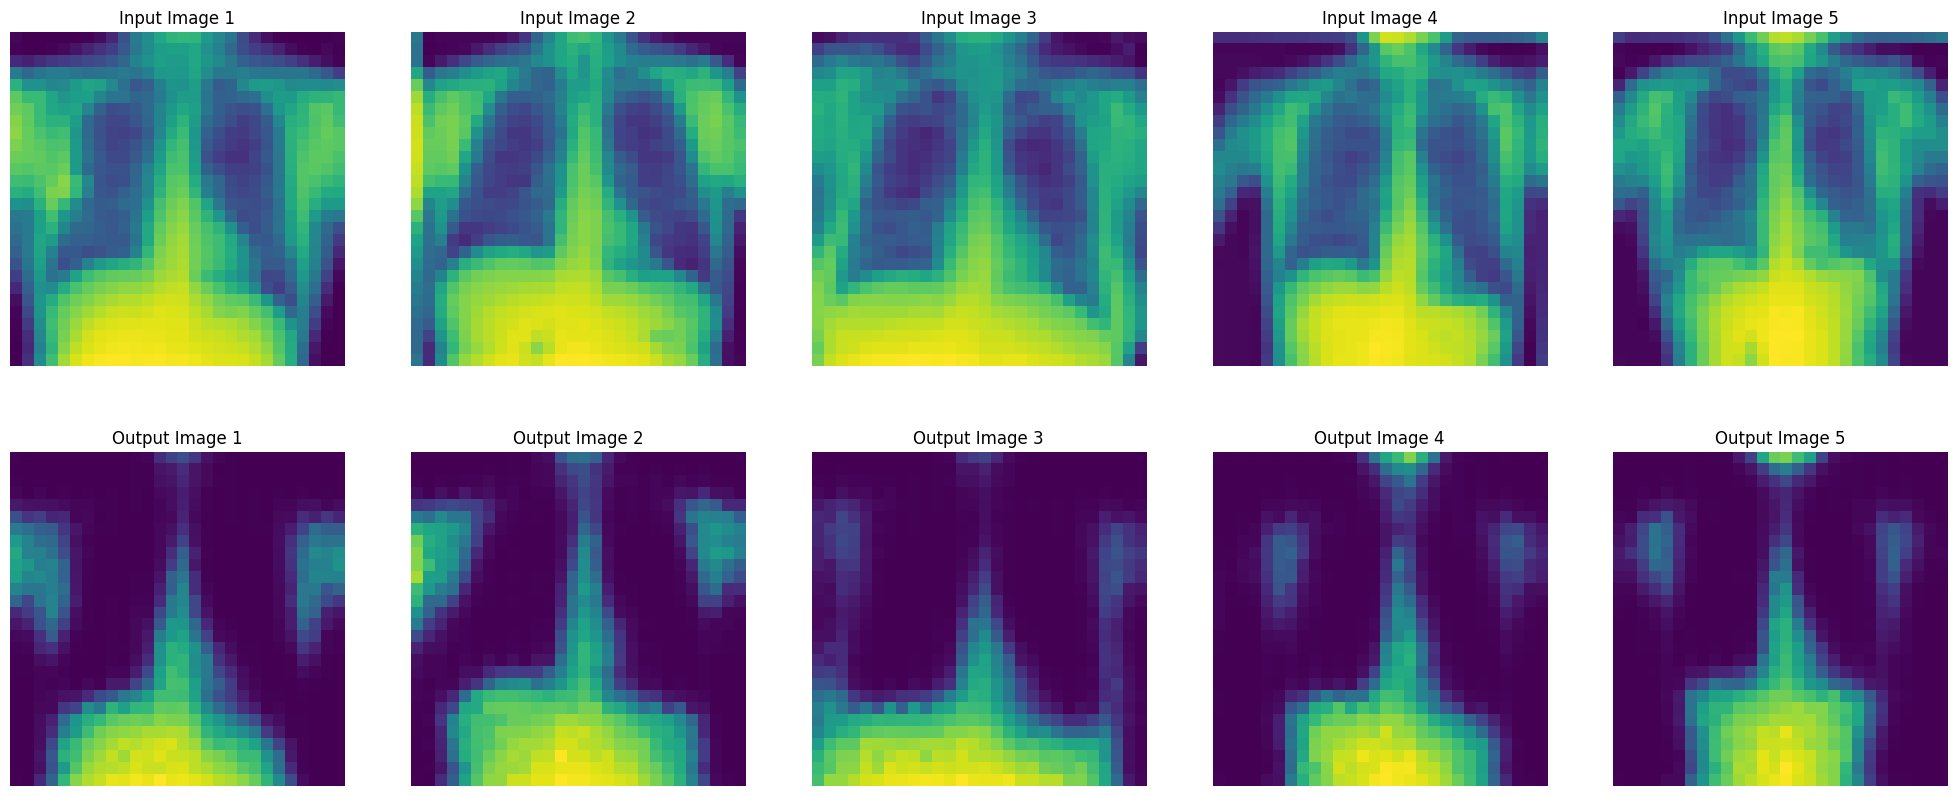

In [111]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_images(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        test_image_set = next(iter(test_loader))
        inputs, _ = test_image_set
        inputs = inputs.to(device)
        outputs = model(inputs)

        plt.figure(figsize=(5 * num_images, 10))

        for i in range(num_images):
            plt.subplot(2, num_images, i + 1)
            plt.imshow(inputs[i].permute(1, 2, 0).cpu())
            plt.title(f'Input Image {i+1}')
            plt.axis('off')

            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(outputs[i].permute(1, 2, 0).cpu())
            plt.title(f'Output Image {i+1}')
            plt.axis('off')

        plt.show()
# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [113]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
model_transfer.state_dict()['layer1.0.weight'] = model_ae.state_dict()['layer1.0.weight']
model_transfer.state_dict()['layer1.0.bias'] = model_ae.state_dict()['layer1.0.bias']
model_transfer.state_dict()['layer1.2.weight'] = model_ae.state_dict()['layer1.2.weight']
model_transfer.state_dict()['layer1.2.bias'] = model_ae.state_dict()['layer1.2.bias']
model_transfer.state_dict()['layer2.0.weight'] = model_ae.state_dict()['layer2.0.weight']
model_transfer.state_dict()['layer2.0.bias'] = model_ae.state_dict()['layer2.0.bias']
model_transfer.state_dict()['layer2.2.weight'] = model_ae.state_dict()['layer2.2.weight']
model_transfer.state_dict()['layer2.2.bias'] = model_ae.state_dict()['layer2.2.bias']
model_transfer.state_dict()['layer3.0.weight'] = model_ae.state_dict()['layer3.0.weight']
model_transfer.state_dict()['layer3.0.bias'] = model_ae.state_dict()['layer3.0.bias']
model_transfer.state_dict()['layer3.2.weight'] = model_ae.state_dict()['layer3.2.weight']
model_transfer.state_dict()['layer3.2.bias'] = model_ae.state_dict()['layer3.2.bias']
model_transfer.state_dict()['layer4.0.weight'] = model_ae.state_dict()['layer4.0.weight']
model_transfer.state_dict()['layer4.0.bias'] = model_ae.state_dict()['layer4.0.bias']
model_transfer.state_dict()['layer4.2.weight'] = model_ae.state_dict()['layer4.2.weight']
model_transfer.state_dict()['layer4.2.bias'] = model_ae.state_dict()['layer4.2.bias']

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 84.83it/s]


Epoch: 1	Loss: 0.7014


100%|██████████| 5/5 [00:00<00:00, 77.01it/s]


Epoch: 2	Loss: 0.6718


100%|██████████| 5/5 [00:00<00:00, 82.99it/s]


Epoch: 3	Loss: 0.6339


100%|██████████| 5/5 [00:00<00:00, 88.23it/s]


Epoch: 4	Loss: 0.5943


100%|██████████| 5/5 [00:00<00:00, 74.92it/s]


Epoch: 5	Loss: 0.5584


100%|██████████| 5/5 [00:00<00:00, 76.65it/s]


Epoch: 6	Loss: 0.5099


100%|██████████| 5/5 [00:00<00:00, 67.55it/s]


Epoch: 7	Loss: 0.4878


100%|██████████| 5/5 [00:00<00:00, 78.52it/s]


Epoch: 8	Loss: 0.4545


100%|██████████| 5/5 [00:00<00:00, 76.14it/s]


Epoch: 9	Loss: 0.4143


100%|██████████| 5/5 [00:00<00:00, 82.35it/s]


Epoch: 10	Loss: 0.3805


100%|██████████| 5/5 [00:00<00:00, 83.98it/s]


Epoch: 11	Loss: 0.3447


100%|██████████| 5/5 [00:00<00:00, 87.59it/s]


Epoch: 12	Loss: 0.3266


100%|██████████| 5/5 [00:00<00:00, 78.93it/s]


Epoch: 13	Loss: 0.3025


100%|██████████| 5/5 [00:00<00:00, 85.59it/s]


Epoch: 14	Loss: 0.2813


100%|██████████| 5/5 [00:00<00:00, 81.07it/s]


Epoch: 15	Loss: 0.2545


100%|██████████| 5/5 [00:00<00:00, 67.70it/s]


Epoch: 16	Loss: 0.2377


100%|██████████| 5/5 [00:00<00:00, 88.41it/s]


Epoch: 17	Loss: 0.2242


100%|██████████| 5/5 [00:00<00:00, 77.43it/s]


Epoch: 18	Loss: 0.2034


100%|██████████| 5/5 [00:00<00:00, 87.27it/s]


Epoch: 19	Loss: 0.1935


100%|██████████| 5/5 [00:00<00:00, 81.40it/s]

Epoch: 20	Loss: 0.1743


In [114]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
Positive rate:  0.9701492537313433
Negative rate:  0.9879518072289156
Balanced accuracy:  0.9790505304801295
acc: 0.980 

Positive rate:  0.4562589243217515
Negative rate:  0.6789067739771966
Balanced accuracy:  0.5675828491494741
acc: 0.575 



# Pneumonia

In [ ]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

In [ ]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

## Transfer learning

In [ ]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

### Transfer learning - Frozen

In [ ]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model

# TODO: Freeze all layers except the FC

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning 